# Processing the data

In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from glob import glob
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import math
from scipy.interpolate import make_interp_spline
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

train_dir = './train/'
test_dir = './test/'
fruits = []
fruits_image = []

for i in os.listdir(train_dir):
    path = os.path.join(train_dir, i)
    if os.path.isdir(path):
        for image_filename in os.listdir(path):
            fruits.append(i)  # name of the fruit
            fruits_image.append(i + '/' + image_filename)
train_fruits = pd.DataFrame(fruits, columns=["Fruits"])
train_fruits["Fruits Image"] = fruits_image

print(train_fruits)

     Fruits          Fruits Image
0     apple     apple/apple_1.jpg
1     apple    apple/apple_10.jpg
2     apple   apple/apple_100.jpg
3     apple   apple/apple_101.jpg
4     apple   apple/apple_102.jpg
..      ...                   ...
395  orange  orange/orange_95.jpg
396  orange  orange/orange_96.jpg
397  orange  orange/orange_97.jpg
398  orange  orange/orange_98.jpg
399  orange  orange/orange_99.jpg

[400 rows x 2 columns]


# Model network structure

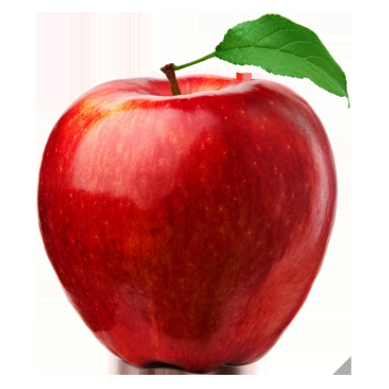

Image Shape -->  (349, 349, 3)
How many different fruits are there -->  4


e:\anaconda3\envs\sunny\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Target Size -->  (256, 256, 3)


In [2]:
img = load_img(train_dir + "./apple/apple_1.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()
array_image = img_to_array(img)
print("Image Shape --> ", array_image.shape)

fruitCountUnique = glob(train_dir + '/*' )
numberOfClass = len(fruitCountUnique)
print("How many different fruits are there --> ",numberOfClass)

# create model
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(256,256,3))) # Modify image size
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(MaxPooling2D(2,2))

# add new layers
model.add(Conv2D(256,(3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(4)) # output
model.add(Activation("softmax"))
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

print("Target Size --> ", (256,256,3))


# Image Enhancement 

In [3]:
# train_datagen = ImageDataGenerator( 
#                                     rescale=1./255,
#                                     validation_split=0.3,
#                                     shear_range=0.3,
#                                     zoom_range=0.3,
#                                     horizontal_flip=True
#                                     )
# Data Augmentation
def background_to_white(image):
    
    image = image.astype('float32') / 255.0
    image = Image.fromarray(np.uint8(image * 255))
    image = image.convert("RGBA")
    background = Image.new("RGBA", image.size, "WHITE")
    result = Image.alpha_composite(background, image)
    result = result.convert("RGB")
    result = np.array(result, dtype=np.float32) / 255.0
    return result

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=30,   # Add Rotation
    width_shift_range=0.2,  # Add horizontal translation
    height_shift_range=0.2,  # Add vertical translation
    brightness_range=[0.8, 1.2], # Add brightness adjustment
    preprocessing_function=background_to_white # Add background to white
)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 60 images belonging to 4 classes.


e:\anaconda3\envs\sunny\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


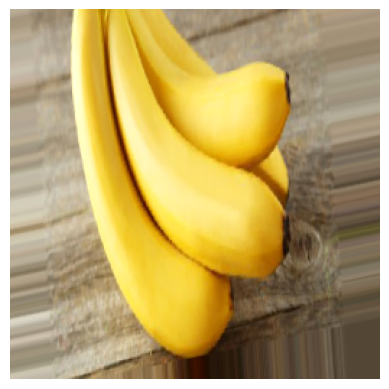

data_batch shape -->  (200, 256, 256, 3)
labels_batch shape -->  (200, 4)


In [4]:
batch_size = 200
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size= (256,256),
                batch_size = batch_size,
                color_mode= "rgb",
                class_mode= "categorical",
                subset = "training"
                )

validation_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(256, 256),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical",
                subset="validation" 
                )

test_datagen = ImageDataGenerator(rescale= 1./255)

test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size= (256,256),
                batch_size = batch_size,
                color_mode= "rgb",
                class_mode= "categorical"
                )

for data_batch, labels_batch in train_generator:
    plt.imshow(data_batch[0])
    plt.axis("off")
    plt.show()
    print("data_batch shape --> ",data_batch.shape)
    print("labels_batch shape --> ",labels_batch.shape)
    break

In [5]:
steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.n / validation_generator.batch_size)

print(steps_per_epoch)
print(validation_steps)


2
1


# Save Model

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    verbose=1,  
    mode='min'  
)

hist = model.fit(
    train_generator,

    epochs=100,
    validation_data=validation_generator,
    # validation_steps= validation_steps
    callbacks=[early_stopping]
)



model.save("model_fruitsv6_test.keras")


Epoch 1/100


e:\anaconda3\envs\sunny\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 23s/step - accuracy: 0.2257 - loss: 14.4977 - val_accuracy: 0.2500 - val_loss: 3.9464
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.2646 - loss: 9.0574 - val_accuracy: 0.2875 - val_loss: 1.3765
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - accuracy: 0.2729 - loss: 1.4465 - val_accuracy: 0.2750 - val_loss: 1.3505
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.3192 - loss: 1.3189 - val_accuracy: 0.5750 - val_loss: 1.2875
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step - accuracy: 0.4204 - loss: 1.2396 - val_accuracy: 0.3125 - val_loss: 1.3669
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.3521 - loss: 1.5725 - val_accuracy: 0.4250 - val_loss: 1.2393
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.4763 - loss: 1.1965 - val_accuracy: 0.4125 - val_loss: 1.2063
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 16s/step - accuracy: 0.4292 - loss: 1.1603 - val_accuracy: 0.4875 - val_loss: 1.1873
Epoch 9

In [7]:


print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,454,286 (1.15 GB)

 Trainable params: 103,151,428 (393.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,302,858 (786.98 MB)

None


In [8]:
model.evaluate(test_generator)
# loss,accuracy = model.evaluate(test_generator)
# print(f'test Accuracy: {accuracy * 100:.2f}')
# print(f'test Loss: {loss * 100:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - loss: 0.9371


[0.9370549917221069, 0.8666666746139526]

# Display the results of model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - loss: 0.9371
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - loss: 0.9371


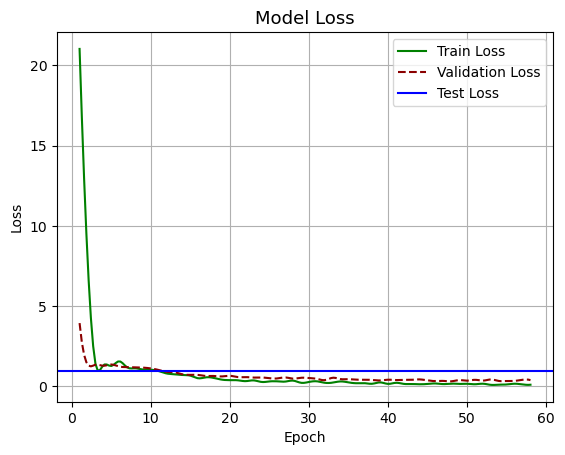

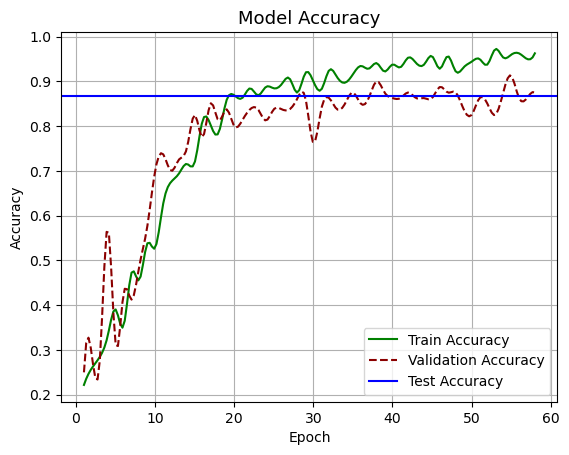

In [9]:
# get data
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

test_loss = model.evaluate(test_generator)[0]
test_accuracy = model.evaluate(test_generator)[1]

# generate interpolation function
epochs = range(1, len(train_loss) + 1)
train_loss_smooth = make_interp_spline(epochs, train_loss)(np.linspace(1, len(train_loss), 200))
val_loss_smooth = make_interp_spline(epochs, val_loss)(np.linspace(1, len(val_loss), 200))
train_acc_smooth = make_interp_spline(epochs, train_acc)(np.linspace(1, len(train_acc), 200))
val_acc_smooth = make_interp_spline(epochs, val_acc)(np.linspace(1, len(val_acc), 200))

# loss
plt.figure()
plt.plot(np.linspace(1, len(train_loss), 200),
         train_loss_smooth, 
         label="Train Loss", 
         color="green")
plt.plot(np.linspace(1, len(val_loss), 200), 
         val_loss_smooth, 
         label="Validation Loss", 
         color="darkred", 
         linestyle="dashed", 
         markeredgecolor="purple", 
         markeredgewidth=2)
plt.axhline(y=test_loss, 
            color='blue', 
            linestyle='-', 
            label='Test Loss')

plt.title("Model Loss", color="black", size=13)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# accuracy
plt.figure()
plt.plot(np.linspace(1, len(train_acc), 200), 
         train_acc_smooth, 
         label="Train Accuracy", 
         color="green")
plt.plot(np.linspace(1, len(val_acc), 200), 
         val_acc_smooth, 
         label="Validation Accuracy", 
         color="darkred", 
         linestyle="dashed", 
         markeredgecolor="purple", 
         markeredgewidth=2)
plt.axhline(y=test_accuracy, 
            color='blue', 
            linestyle='-', 
            label='Test Accuracy')

plt.title("Model Accuracy", color="black", size=13)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()





# Identifying fruits

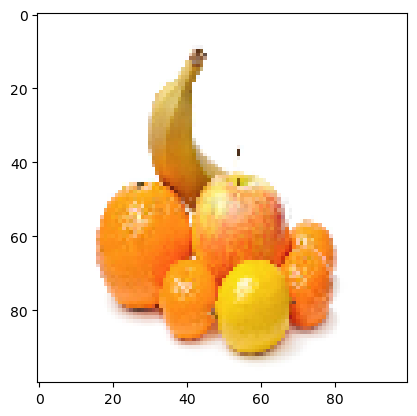

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted class: [3]
{'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}


In [25]:
model = load_model('model_fruits.keras')


img = load_img("./test/mixed/mixed_21.jpg",target_size=(100,100))
plt.imshow(img)
plt.show()

array_image = img_to_array(img)
array_image = array_image * 1./255
x = np.expand_dims(array_image, axis=0)
images = np.vstack([x])
predictions = model.predict(images, batch_size=10)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)
train_dir = './train/'

print(train_generator.class_indices)


# hypothesis Red banana

In [ ]:
def combine_predictions(shape_pred, color_pred, weights=[0.5, 0.5]):
    return np.argmax(weights[0] * shape_pred + weights[1] * color_pred, axis=1)

shape_pred = shape_model.predict(test_gray_images)
color_pred = color_model.predict(test_color_images)
combined_pred = combine_predictions(shape_pred, color_pred)